# Woulda, Coulda, Shoulda : Counterfactually-Guided Policy Search

 *Woulda, Coulda, Shoulda : Counterfactually-Guided Policy Search*, **l. Buesing, T. Weber, Y. Zwols et al.** 2018
 
<img src="image/intro.png" width=600 height=100 />


Goal : leverage possible (yet to prove) advantages of *counterfactual* reasoning for learning decision making in RL.

What *would have happened*, had you chose a different action ? Can we simulate counterfactual (and plausible) experiences instead of large amounts of real experiences (which can be costly to acquire)?

Solution : the authors proposed a new algorithm for learning policies in PO-MDPs from off-policy experience, called the Counterfactually-Guided Policy Search (**CF-GPS**). It explicitely considers alternative outcomes, allowing the algorithm to make better use of experience data.

_________________

**<a id="toc"></a>Table of Content**

[1. Introduction to Causality](#intro)<br>
   - [1.1 Preliminaries](#Preliminaries)<br>
   - [1.2 Structural Causal Model](#Structural-Causal-Model)<br>
   - [1.3 Counterfactual Inference (CFI) in SMCs](#scm)<br>
 
[2. Policy Evaluation](#policy)
   - [2.1 Off-policy evaluation](#off-policy)<br>
   - [2.2 Learn a policy](#)<br>


[3. Sokoban Game](#Sokoban)<br>

[4. Train an RL Agent to evaluate](#rl-training)<br>


[4. Draw : A Recurrent Neural Network For Image Generation](#draw)<br>
 - [4.1 Train model](#draw)<br>
 - [4.2 Results](#draw)<br>
 - [4.3 Add Constraint](#draw)<br>
 
[5. Counterfactual Policy Evaluation](#countereval)

[6. Counterfactually-Guided Policy Search](#counter)

[7.Discussion](#discuss)

[8. Appendix Results](#appendix)


_______________________________

Packages

In [88]:
import os
import torch
import numpy as np
from torch import tensor
import matplotlib.pyplot as plt
%matplotlib inline

_______________________________

## <a id="intro"></a> 1. Introduction to Causality

### Preliminaries

- X, Y, Z (capital letters) are random variables, and x, y, z particular values.
- if X vector-valued rv with distrib P (density p), $Y \subset X$ with marginal $P_Y$ (dens. $p_Y$)
- **POMDP** : Partially Observable Markov Decisino Process $(S_t, A_t, O_t, R_t, \gamma)$. In their settings, observation $O_t$ includes $R_t$,  $\gamma \in [0,1]$ discounted factor. Stochastic policies $\pi(a_t | h_t)$ over actions conditioned on observation history $H_t = (O_1, A_1, ..., A_{t-1}, O_t)$. 

### Structural Causal Model

**Definition 1 - Structural Causal Model** : 

A SCM over $X=(X_1, ..., X_N)$, denoted $\mathcal{M}$, is given by a DAG (Directed Acyclic Graph) denoted $\mathcal{G}$, over nodes X, indep. noise rvs $U=(U_1, ...U_N)$ (with distrib $P_{U_i}$) and function $f_1, ..., f_N$ s.t $X_i = f_i(\mbox{pa}_i, U_i)$ (with $\mbox{pa}_i \subset X$, parents of $X_i$ in $\mathcal{G}$). An SCM entails a distribution P with density $p$ over $(X,U)$.

Rmks : $U$ are called *scenarios*, and $f_i$ causal mechanisms.

**Definition 2 - Intervention in SCM** : 

An intervention $I$ in an SCM $\mathcal{M}$ consists in replacing some of the original $f_i(\mbox{pa}_i, U_i)$ with other functions $f_i^I(\mbox{pa}_i^I, U_i)$ where $\mbox{pa}_i^I$ are the parents in the new DAG, $\mathcal{G}^I$. The resulting SCM is denoted $\mathcal{M}^{\mbox{do(I)}}$ with distribution  $P^{\mbox{do(I)}}$  and density  $p^{\mbox{do(I)}}$ 

**Alice's job choice :**

Drescription : Alice had two job offers from companies $a_1, a_2$ and decided to join $a_1$ (because of the salary, but bit reluctant for the rest). One month later, she has an echo for a friend about $a_2$. What would have happen if she had join $a_2$? Did she make a regrettable decision ?

- Context $U_c$, given before she takes an action $A$ ($A \in \{a_1, a_2\}$)
- Potential indeterminacy $U_a$ in Alice's decision making.
- Alice's decision $A = f_{\pi}(U_c, U_a)$.
- Outcome $O = f_{o}(A, U_c, U_o)$ depends also on $U_o$ (all relevant, unobserved, complex properties of both companies).

```python
a = f1(u_c, u_a)
o = f2(a, u_c, u_o)
```

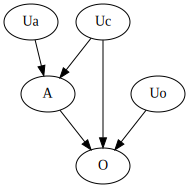

In [2]:
from causalgraphicalmodels import CausalGraphicalModel, StructuralCausalModel
from causalinference import CausalModel

sprinkler = CausalGraphicalModel(nodes=["Ua", "Uc", "Uo", "A", "O"],
                                 edges=[("Ua", "A"), ("Uc", "A"), ("Uc", "O"), ("Uo", "O"), ("A", "O")])
sprinkler.draw()

Intruition : Alice had some initial intuition given by context $U_c$, and alongside some potential indeterminacy captured by $U_a$, she took a decision $A = f_\pi(U_c, U_a)$. The outcome $O$ will then depends on her decision $A$, the context $U_c$ but also on all the relevant unobserved properties given by the scenario $U_o$.

Given a fix scenario $u_o$, we can reason about alternate outcomes  $f_{o}(a_1, u_c, u_o)$ and $f_{o}(a_2, u_c, u_o)$

**SMC with POMDP** with initial state $U_{s_1} = S_1$, states $S_t$ and histories $H_t$ 

In [3]:
nodes = ["U_o1", "U_s1", "O_1"]
edges = [("U_o1", "O_1" ), ("U_s1","O_1" )]

for t in range(2, 5): 
    nodes.extend(["U_o%s"%t, "U_s%s"%t, "U_a%s"%(t-1), "O_%s"%t, "H_%s"%(t-1),  "A_%s"%(t-1), "S_%s"%t ])
    edges.extend([("O_%s"%(t-1),"H_%s"%(t-1)), 
                  ("H_%s"%(t-1),  "A_%s"%(t-1)), ("U_a%s"%(t-1), "A_%s"%(t-1)),
                  ("A_%s"%(t-1), "S_%s"%t ), ("U_s%s"%t, "S_%s"%t), 
                  ( "S_%s"%t,  "O_%s"%t), ("U_o%s"%t, "O_%s"%t)])
    if t == 2 :
        edges.append(("U_s1", "S_2"))
    else :
        edges.append(("S_%s"%(t-1), "S_%s"%t))
    
sprinkler = CausalGraphicalModel(nodes=nodes, edges=edges)


SCM for a POMDP with initial state U_s1 = S_1, state S_t and histories H_t


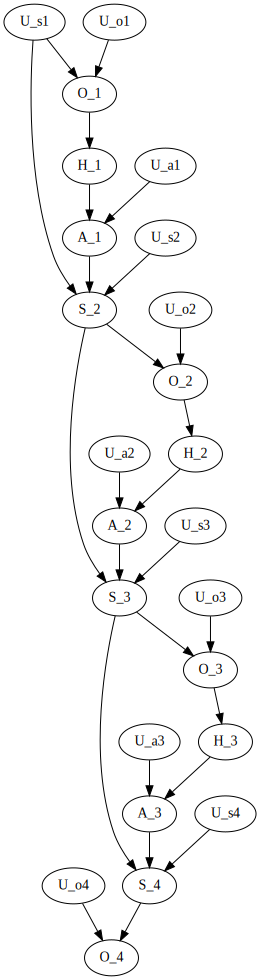

In [4]:
print('SCM for a POMDP with initial state U_s1 = S_1, state S_t and histories H_t')
sprinkler.draw()

__________________________

### <a id="scm"></a> Counterfactual Inference (CFI) in SMCs

- *counterfactual query* : $(\hat{x}_o, I, X_q)$ of an observation $\hat{x}_o$ of some rvs $X_o \subset X$, an intervention $I$ and query variables $X_q \subset X$. 

To read : "having observed  $\hat{x}_o$ , we want to infer what $X_q$ *would have been*, had we done an intervention I, while *keeping everything else the same*".

How to answer that query ? 
1. Infer the unobserved noise source conditioned on the observations $\hat{x}_o$ (i.e compute 
$p(U|\hat{x}_o)$ and replace the prior $p(U)$ with the new $p(U|\hat{x}_o)$.<br>**Results in new SCM, 
$\mathcal{M}_{\hat{x}_o}$.**
2. Perform intervention $I$ on $\mathcal{M}_{\hat{x}_o}$. Yields $\mathcal{M}_{\hat{x}_o}^{\mbox{do(I)}}$ which
entails new counterfactual distributoin $p^{\mbox{do(I)}|\hat{x}_o}$.<br> **Return marginal** $p^{\mbox{do(I)}|\hat{x}_o}(x_q)$


______________
**Algo : Counterfactual Inference (CFI)**

**Input** : data $\hat{x}_o$, an SCM $\mathcal{M}$, an intervention I, a query $X_q$.
1. Sample noise variables from posterior : $\hat{u} \sim p(u|\hat{x}_o)$
2. Replace noise distribution in $p$ with $\hat{u}$ : $p(u) \leftarrow \delta(u - \hat{u})$
3. Perform intervention I : $f_i \leftarrow f_i^I$
4. Simulate and return from the resulting model $x_q \sim p^{\mbox{do(I)}}(x_q|\hat{u})$
_________________

#### Alice's choice

In [5]:
scm = StructuralCausalModel({
    "Uc": lambda           n_samples:  np.random.binomial(n=1,p=0.7,size=n_samples),
    "Ua": lambda           n_samples : np.random.normal(loc=0, scale=0.1),
    "Uo": lambda           n_samples:  np.random.normal(loc=0, scale=0.1),
    "A": lambda Uc, Ua,    n_samples:  (np.mean(Uc)*Ua)**2,
    "O": lambda A, Uo, Uc, n_samples : A*Uo*np.mean(Uc),
})

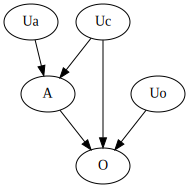

In [6]:
scm.cgm.draw()

In [7]:
#ds_intervention = scm.do('A').do('O').sample(n_samples=100,
#    set_values={"A": np.random.binomial(p=0.5, n=1, size=100), 
#               "O": np.random.binomial(p=0.5, n=1, size=100)})

___
**Lemma 1 : CFI for simulation**

Let observations $\hat{x}_0 \sim p$ come from a SCM $\mathcal{M}$ with density $p$.<br>Then the counterfactual density $p^{\mbox{do(I)}|\hat{x}_0}$ is an unbiased estimator of $p^{\mbox{do(I)}}$, i.e.
$ \mathbb{E}_{\hat{x}_0 \sim p} [ p^{\mbox{do(I)}|\hat{x}_0}(x)] = p^{\mbox{do(I)}}$

___
**Corollary 1 : Mixed counterfactual and prior simulation from an SCM**

Assume we have observations $\hat{x}_0 \sim p$. <br>We can simulate from $\mathcal{M}$, under any intervention $I$, i.e. obtain unbiased samples from $\mathcal{M}^{\mbox{do(I)}}$ by :
1. a. from the posterior $p(u_{CF}|\hat{x}_0)$, sampling values $u_{CF}$ for an arbitrary subset $U_{CF} \subset U$ 
<br>b. sampling the remaining $U_{Prior} := U\\U_{CF}$ from the prior $p(u_{Prior})$
2. Computing X with noise $u = u_{CF} \cup u_{Prior}$

___



**Example** : 

Alice's choice : having oberved the context noise $\hat{u}_c$ and chosen company $\hat{a} = a_1$ that lead to concrete outcome $\hat{o}$, she can try : 
- to infer the underlying scenario $\underline{u_o} \sim p(u_o|a_1, \hat{u}_c, \hat{o})$
- reason counterfactually about new outcome X  had she joined $a_2$ : X = $f_o(a_2, \hat{u}_c, \underline{u_o})$ (**Corollary 1**)

This should help her to make better decision in the future (in similar scenarios) by changing her decision making process $f_\pi(U_c, U_a)$. Using counterfactual predictions sould be preferred instead of learning from her own new experiences.

Rmq : non independence of sampled noise variable $U_{CF}$ from posterior $P_{U_{CF}|\hat{x}_o}$.

_______________________

## 2. <a id="policy"></a>Policy Evaluation <span  style="float:right">[[toc]](#toc)</span >

### <a id="off-policy"></a> Off-policy evaluation : counterfactual reasoning in SCM for policy evaluation

**Policy Evaluation (PE)** :

The goal is to determine the value of a policy $\pi$, ie its expected return $\mathbb{E}_{\pi}[G]$ without running the policy itself. 

___________

Hyp : data $D=\{\hat{h}^i_T\}_{i=1,..,N}$ of logged episodes $\hat{h}^i_T$ from running a behavior policy $\mu$. Also assume that $\mathcal{M}$ is a SCM.<br> (Rmq : $\mu$ chosen to be random)

**Model-based policy evaluation (MB-PE)** :

Estimate the policy on synthetic data, ie estimate $\mathbb{E}_{p^{\pi}}[G]$, having access to the model $\mathcal{M}$. Drawbacks : any bias in $\mathcal{M}$ propagates from $p^{\pi}$ to the estimate $\mathbb{E}_{p^{\pi}}[G]$. The naive MB-PE with a SCM simpluy consists of sampling the scenarios $U \sim P_U$ from the prior and them simulating a trajectory $\tau$ from the functions $f_i$ and computing its return.

**Counterfactual Off-Policy policy evaluation (CF-PE)** :

Idea : given data $D$, off-policy evaluation of $\pi$ can be sees as a counterfactual query with data $\hat{h}^i_T$, under intervention $I(\mu \to \pi)$ by querying variable $G$ (episode return). I.e sample scenarios from the posterio $u^i \sim p^{\mu}(.|\hat{h}^i_T)$ instead of sampling from the prior (as in MB-PE)$. (**unbiased estimate guaranted by Lemma 1

___

**Corollary 2 : CF-PE unbiased** : 

Assuming no model mismatch, CF-PE is unbiased.
____________
**Algo : Counterfactual Policy Evaluation (CF-PE)**
0. Input : an SCM $\mathcal{M}$, initial policy $\pi^0$, number of trajectory samples N.
1. for $i \in \{1, ..., N\}$ do : <br>
    a. Sample from the replay buffer $\hat{h}^i_T \sim D$  <br>
    b . Counterfactual evaluation of return $g_i = \mbox{CFI}(\hat{h}^i_T, \mathcal{M}, I(\mu \to \pi), G)$
2. Return $\frac{1}{N} \sum_{i=1}^N g_i$

# <a id="Sokoban"></a> Sokoban Game <span  style="float:right">[[toc]](#toc)</span >

The *Sokoban* game is a japanese puzzle that an agent is suppose to solve by pushing different boxes onto targets. 

  **Description** : an agent is sutuated in a $10 \times 10$ grid world (or $7 \times 7$ for the *small* version) and is allowed to take five actions, which are moving (and pushing) to one of four adjacent tiles, plus a NOOP operation. The goal is to push two or three boxes onto two or three immobile targets. As boxes cannot be pulled, many actions results irreversibly in unsolvable states. Episode are length $T=50$, pushing a box onto a target yieds a reward of 1, removing a box from a target yiels a reward of -1 and solving a level results in a additional reward of 10.

*Latest Version*

In [83]:
import gym
import gym_sokoban
from sokoban_wrappers import make_sokoban, render_po, render_full, ResetfromBuffer

import random ; random.seed(1)

**10x10**

Action Meaning : {0: 'no operation', 1: 'push up', 2: 'push down', 3: 'push left', 4: 'push right'} 
Observation Space : Box(10, 10, 7)


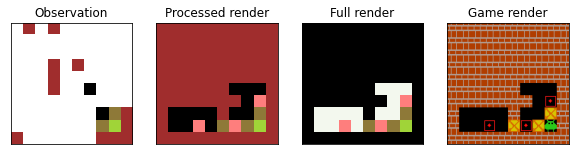

In [84]:
env = make_sokoban(po_wrapper=True, action_wrapper=True, mask_proba=0.9)
obs = env.reset()
print('Action Meaning :', env.get_action_meanings(), '\nObservation Space :', env.observation_space)

fig, ax = plt.subplots(1,4, figsize=(10,5))
for a in fig.axes: a.get_xaxis().set_visible(False) ; a.get_yaxis().set_visible(False) ;
    
render = [env.render(mode=mode) for mode in ['tiny_rgb_array', 'rgb_array']]
ax[0].imshow(render_po(obs)) ; ax[0].set_title('Observation')
ax[1].imshow(render_full(env.room_state)) ; ax[1].set_title('Processed render')
ax[2].imshow(render[0]) ; ax[2].set_title('Full render')
ax[3].imshow(render[1]) ; ax[3].set_title('Game render') ; plt.show()

Remarks : 
1. as generating a room of size 10x10 that complies with all the constraint (nb of boxes and targets, solvable levels etc ..), it takes a non-negligeable timme to reset the environement. It goes so much faster with a 7x7 room, as constraints are ligther.
2. setting the seed fixes the grid layout but not the item's position.

**7x7**

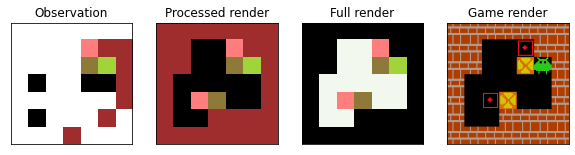

In [88]:
env = make_sokoban(env_name='Sokoban-small-v0', po_wrapper=True, action_wrapper=True, mask_proba=0.9)
obs = env.reset()

fig, ax = plt.subplots(1,4, figsize=(10,5))
for a in fig.axes: a.get_xaxis().set_visible(False) ; a.get_yaxis().set_visible(False) ;
    
render = [env.render(mode=mode) for mode in ['tiny_rgb_array', 'rgb_array']]
ax[0].imshow(render_po(obs)) ; ax[0].set_title('Observation')
ax[1].imshow(render_full(env.room_state)) ; ax[1].set_title('Processed render')
ax[2].imshow(render[0]) ; ax[2].set_title('Full render')
ax[3].imshow(render[1]) ; ax[3].set_title('Game render') ; plt.show()

**Sakoban Game - Test Reset**

We added a additinal wrapper to allow a player to reset the environment by providing the initial room configuration

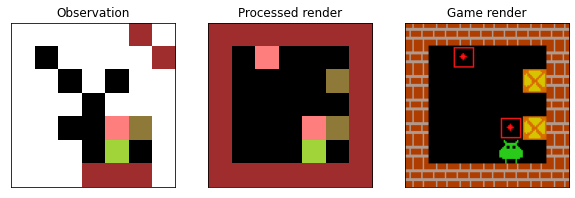

In [11]:
array = np.array([[0,0,0,0,0,0,0],
                  [0,1,2,1,1,1,0],
                  [0,1,1,1,1,4,0],
                  [0,1,1,1,1,1,0],
                  [0,1,1,1,2,4,0],
                  [0,1,1,1,5,1,0],
                  [0,0,0,0,0,0,0]], dtype = np.uint8)

env = make_sokoban(env_name='Sokoban-small-v0', po_wrapper=True, action_wrapper=True, mask_proba=0.7, allow_reset=True)
obs = env.reset(**{'array':array})

fig, ax = plt.subplots(1,3, figsize=(10,10))
for a in fig.axes: a.get_xaxis().set_visible(False) ; a.get_yaxis().set_visible(False) ;
    
ax[0].imshow(render_po(obs)) ; ax[0].set_title('Observation')
ax[1].imshow(render_full(env.room_state)) ; ax[1].set_title('Processed render')
ax[2].imshow(env.render(mode='rgb_array')) ; ax[2].set_title('Game render') ;

To simplify training we generated a buffer of solvable levels which the environement will be sampling its initial state from. Argument *allow_reset* set to True.

Room nb: 20


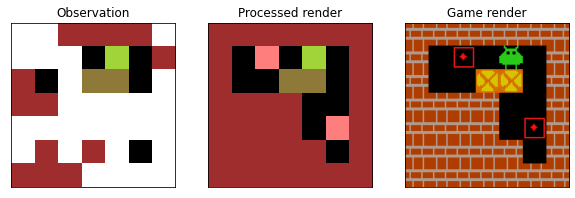

In [12]:
env = make_sokoban(env_name='Sokoban-small-v0', po_wrapper=True, action_wrapper=True, mask_proba=0.7, allow_reset=True)
env = ResetfromBuffer(env, 100) ; obs = env.reset()
print('Room nb:', env.rand)

fig, ax = plt.subplots(1,3, figsize=(10,10))
for a in fig.axes: a.get_xaxis().set_visible(False) ; a.get_yaxis().set_visible(False) ;
    
ax[0].imshow(render_po(obs)) ; ax[0].set_title('Observation')
ax[1].imshow(render_full(env.room_state)) ; ax[1].set_title('Processed render')
ax[2].imshow(env.render(mode='rgb_array')) ; ax[2].set_title('Game render') ;

The generated levels can be found in the following numpy-like file :
    
    rooms = np.load('rooms7x7.npy')
    plt.imshow(render_full(rooms[id]))



**Generate levels and save into buffer**

In [13]:
from tqdm import tqdm_notebook as pbar
import numpy as np

if False :
    
    nb_room_generated = 1000
    rooms = np.zeros((nb_room_generated,7,7), dtype=np.uint8)
    
    for r in pbar(range(nb_room_generated)):
        env = make_sokoban(env_name='Sokoban-small-v0', po_wrapper=True, action_wrapper=True, mask_proba=0.7)
        room = env.room_state
        rooms[r] = room     
        np.save('data/rooms7x7.npy', rooms)

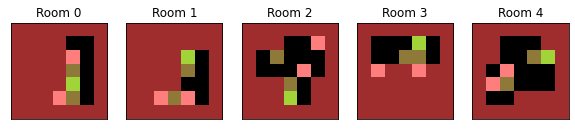

In [14]:
rooms = np.load('data/rooms7x7.npy')

fig, ax = plt.subplots(1,5, figsize=(10,10))
for a in fig.axes: a.get_xaxis().set_visible(False) ; a.get_yaxis().set_visible(False) ;

for i in range(5):
    ax[i].imshow(render_full(rooms[i])) ; ax[i].set_title('Room {}'.format(i))

_______________________

## <a id="rl-training"></a> Train an RL Agent <span  style="float:right">[[toc]](#toc)</span >
### Generate a Policy $\pi$ to evaluate


#### 1.IMPALA 
*IMPALA : Scalable distributed Deep RL with importance weighted actor-learner architectures*, **Espeholt et al** (2018)<br>
https://deepmind.com/blog/article/impala-scalable-distributed-deeprl-dmlab-30

#### 2. A3C

Train the agent using the baby-A3C algorithm proposed by Sam Greydanus (MIT License) (https://github.com/greydanus/baby-a3c)
:

    ! python baby_a3c.py --env Sokoban-small-v0 --processes 10

In [2]:
import sys ; sys.path.append('C:/Users/damie/Desktop/WCS/baby_a3c')
from test_a3c import run_test, create_env, SokobanPolicy

model_path = 'baby_a3c/sokoban-small-v0/model.7.tar'
model = SokobanPolicy(channels=7, memsize=256, num_actions=5)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [3]:
env = create_env('Sokoban-small-v0', mask_proba = 0.7,nb_room = 100) #; env.reset(provide_rand=2)
run_test(model, env, render = True, sleep_time = 0.1, stochasticity = 1)

{'run_epr': tensor([1.], dtype=torch.float64),
 'run_loss': tensor([0.], dtype=torch.float64),
 'episodes': tensor([1.], dtype=torch.float64),
 'frames': tensor([50.], dtype=torch.float64)}

____________________________________________

### Data Collection $\hat{h}_T$ under policy $\mu$

The data $\hat{h}_T$ is collected under a uniform random policy $\mu$. Let's do a rollout of an episode with T=50 :

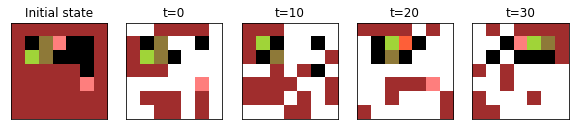

In [92]:
from rollout import rollout, make_sokoban
from sokoban_wrappers import make_sokoban, render_po, render_full

history = rollout(T=50, env_name='Sokoban-small-v0', po_wrapper=True, action_wrapper=True, mask_proba=0.7)

fig, ax = plt.subplots(1,5, figsize=(10,10))
for a in fig.axes: a.get_xaxis().set_visible(False) ; a.get_yaxis().set_visible(False) ;

ax[0].imshow(render_full(history['initial_state']))
ax[0].set_title('Initial state')
for it, i in enumerate(range(0,40,10)):
    arr = history['obs'][i]
    ax[it+1].imshow(render_po(arr))
    ax[it+1].set_title('t={}'.format(i))

## <a id="draw"></a>Draw : A Recurrent Neural Network For Image Generation <span  style="float:right">[[toc]](#toc)</span >

*DRAW: A Recurrent Neural Network For Image Generation* K. Gregor, I. Danihelka, Alex Graves, et al https://arxiv.org/abs/1502.04623

The only part of the model that remains to be identified is the initial state distribution $p(U_{s_1})$. The authors proposed to use the DRAW model, a convolutional and recurrent neural network for image generation : 
1. first the obersvational history $\hat{h}_T$ is summarized by a convolutional LSTM.
2. Fed into a DRAW model to generate $U_{s_1} \in \{0,1\}^{10 \times 10 \times 7}$

In [87]:
from DRAW.draw_model import DRAWModel, train_draw, params
from sokoban_wrappers import make_sokoban, render_po, render_full
from check_sokoban import fix_player, fix_item, predict_initial_state,\
                            start_allowed, reward_correction, quality_check

Load the data

In [4]:
files = sorted(os.listdir('DRAW/data/7x7/'))
max_folder = min(len(files), 10)
split = max_folder - int(0.1*max_folder)

data_train = np.load('DRAW/data/7x7/sokoban_000.npy')
data_test = np.load('DRAW/data/7x7/sokoban_{}.npy'.format(str(split).zfill(3)))

for i in range(1,split):
    data_train = np.concatenate([data_train, np.load('DRAW/data/7x7/sokoban_{}.npy'.format(str(i).zfill(3)))], axis=0)
for i in range(split, max_folder):
    data_test = np.concatenate([data_test, np.load('DRAW/data/7x7/sokoban_{}.npy'.format(str(i).zfill(3)))], axis=0)

data_train = np.transpose(data_train, (0, 1, 4, 2, 3))
data_test = np.transpose(data_test, (0, 1, 4, 2, 3))
print('Train data :', data_train.shape, '\nTest data  :', data_test.shape)

Train data : (450, 51, 7, 7, 7) 
Test data  : (100, 51, 7, 7, 7)


__________________________________

### <a id="countereval"></a> Counterfactual Policy Evaluation (CF-PE) <span  style="float:right">[[toc]](#toc)</span >

**Pseudo-Algo : Counterfactual Policy Evaluation (CF-PE)**
0. Input : 
    - an SCM $\mathcal{M}$, 
    - policy $\pi$ to evaluate 
    - number of trajectory samples N.
<br><br>
1. for $i \in \{1, ..., N\}$ do : <br>
 - Sample from the replay buffer $\hat{h}^i_T \sim D$  <br>
 - Counterfactual evaluation of return $g_i = \mbox{CFI}(\hat{h}^i_T, \mathcal{M}, I(\mu \to \pi), G)$
<br><br>
2. Return $\frac{1}{N} \sum_{i=1}^N g_i$

**Application**

In our case study, the pseudo algo will give the following steps:
0. Input : 
    - an SCM $\mathcal{M}$, the *custom_reset* environement of our sokoban game
    - number of trajectory samples N.
    - initial random policy $\mu$ that generated the data history $\{\hat{h}^i_T\}_{i=0..N}$
    - a policy $\pi$ we want to evaluate
<br><br>
1. for $i \in \{0, ..., N\}$ do : <br>
 - Sample a random rollout from the replay buffer $\hat{h}^i_T \sim D$  <br>
 - **Counterfactual query** : $\mbox{CFI}(\hat{h}^i_T, \mathcal{M}, I(\mu \to \pi), G)$
     - Using the DRAW generative model, sample an initial state $\hat{u}_i \sim \mbox{DRAW}(.|\hat{h}^i_T)$ conditioned on the history.
     - perform a rollout from the sampled initial state $\hat{u}_i $ using the policy $\pi$.
     - compute and return the episode return $g_i$
<br><br>
2. Return $\frac{1}{N} \sum_{i=1}^N g_i$

**Counterfactual Query**

In [6]:
from rollout import rollout, make_sokoban
from sokoban_wrappers import make_sokoban, render_po, render_full
import numpy as np

T = 50
channel, W, H = 7,7,7

params['T'] = T ; params['z_size'] = 50#32
params['A'] = H ; params['B'] = W ; params['channel'] = channel
params['read_N'] =  params['write_N'] = H
params['conv'] = True

device = 'cpu'
params['device'] = device
draw_model = DRAWModel(params).to(device)
optimizer = optim.Adam(draw_model.parameters(), lr=params['learning_rate'], betas=(params['beta1'], 0.999))

checkpoint = True
model_path = 'DRAW/checkpoint/7x7/{}/model_epoch_40'.format(T)

if checkpoint :
    draw_model.load_state_dict(torch.load(model_path)['model'])
    optimizer.load_state_dict(torch.load(model_path)['optimizer'])    
    params = torch.load(model_path)['params']

#initial_states = np.load('data/rooms7x7.npy')[:100]

Conv LSTM as encoder


Counterfactual episode reward : 12.0


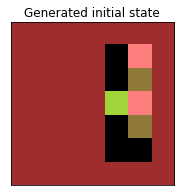

In [7]:
fig, ax = plt.subplots(1,1, figsize=(3,3))
for a in fig.axes: a.get_xaxis().set_visible(False) ; a.get_yaxis().set_visible(False) ;

init_state = predict_initial_state(draw_model, data_train[2,1:(T+1)])
env = create_env('Sokoban-small-v0', nb_room = 0)
res = run_test(model, env, render = False, sleep_time = 0.1, **{'array':init_state.argmax(0)})

ax.imshow(render_full(init_state.argmax(0))) ; ax.set_title('Generated initial state')
print('Counterfactual episode reward :', float(res['run_epr']))

In [15]:
def PE_Sokoban(policy, n_samples, stochasticity = 1):
    epr = []
    for i in range(n_samples):
        env = create_env('Sokoban-small-v0', nb_room = 100)
        res = run_test(policy, env, stochasticity = stochasticity, render = False)
        epr.append(float(res['run_epr']))
    return np.mean(epr)

In [13]:
PE_Sokoban(model, 30)

6.766666666666667

In [70]:
def CF_PE_Sokoban(policy, draw_model, n_samples):
    epr = {}
    for i in range(n_samples):
        
        # Select randomly a room id
        ind = np.random.randint(100)
        env = create_env('Sokoban-small-v0', nb_room=100,  mask_proba=0.7)
        env.reset()
        true_initiale_state = env.room_state.copy()
        history = rollout(T=draw_model.T, env_name='Sokoban-small-v0', po_wrapper=True, 
                          action_wrapper=True, mask_proba=0.7,  allow_reset=True, array = true_initiale_state)
        history = np.concatenate([np.expand_dims(obs, axis=0) for obs in history['obs']], axis=0)
        init_state = predict_initial_state(draw_model, history, transpose = True)
        init_state_copy = init_state.argmax(0).copy()      

        for stochasticity in [0.3, 0.6, 1]:
            if start_allowed(init_state_copy.copy()):
                
                env = create_env('Sokoban-small-v0', nb_room = 0,  mask_proba=0.7)
                res = run_test(policy, env, render = False, stochasticity=stochasticity,
                                       **{'array':init_state_copy.copy()})
                reward = float(res['run_epr'])
                reward = reward_correction(init_state_copy.copy(), reward)
                epr[stochasticity] = epr.get(stochasticity, []) + [reward]
            else : 
                epr[stochasticity] = epr.get(stochasticity, []) + [0]

    return epr

In [102]:
pe_results = CF_PE_Sokoban(model, draw_model, 30)

for i in pe_results.keys():
    print('PE for policy with stochasticity {} : {:.2f}'.format(1-i, np.mean(pe_results[i])))

PE for policy with stochasticity 0.7 : 2.83
PE for policy with stochasticity 0.4 : 4.37
PE for policy with stochasticity 0 : 7.13


### Experimental Results on Policy Evaluation 

In [84]:
device = 'cpu'
draw_model = DRAWModel(params).to(device)
optimizer = optim.Adam(draw_model.parameters(), lr=params['learning_rate'], betas=(params['beta1'], 0.999))
import os
results = {}
for T in [1, 5, 20, 50]:
    print(T)
    folder_path = 'DRAW/checkpoint/7x7/{}'.format(T)
    model_path = folder_path + '/' + sorted(os.listdir(folder_path))[-1]
    print(model_path)
    params = torch.load(model_path)['params']
    params['device'] = device
    
    draw_model = DRAWModel(params).to(device)
    optimizer = optim.Adam(draw_model.parameters(), lr=params['learning_rate'], betas=(params['beta1'], 0.999))

    draw_model.load_state_dict(torch.load(model_path)['model'])
    optimizer.load_state_dict(torch.load(model_path)['optimizer'])    

    results[T] = CF_PE_Sokoban(model, draw_model, 100)

Conv LSTM as encoder
1
DRAW/checkpoint/7x7/1/model_epoch_30
Conv LSTM as encoder
5
DRAW/checkpoint/7x7/5/model_epoch_30
Conv LSTM as encoder
20
DRAW/checkpoint/7x7/20/model_epoch_20
Conv LSTM as encoder
50
DRAW/checkpoint/7x7/50/model_epoch_40
Conv LSTM as encoder


In [101]:
true_pe = {}
for s in [0.3, 0.6, 1]:
    true_pe[s] = PE_Sokoban(model, 300, stochasticity = s)    
    print('True PE with stochasticity {} : {:.2f}'.format(1-s, np.mean(true_pe[s])))

True PE with stochasticity 0.7 : 2.61
True PE with stochasticity 0.4 : 4.50
True PE with stochasticity 0 : 7.53


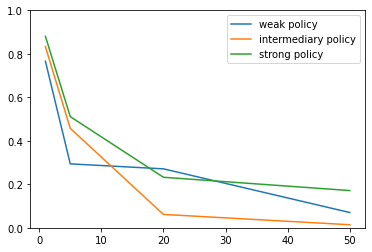

In [86]:
labels = ['weak', 'intermediary', 'strong']
ax = plt.plot()
for i, s in enumerate([0.3, 0.6, 1]):
    l = []
    for T in [1, 5, 20, 50]:
        l.append(abs((np.mean(results[T][s]) - true_pe[s])/true_pe[s]))
    plt.plot([1, 5,  20, 50], l, label = '{} policy'.format(labels[i]))
plt.ylim([0,1])
plt.legend()

## <a id="counter"></a> Counterfactually-Guided Policy Search <span  style="float:right">[[toc]](#toc)</span >

We assume that we have a model $\mathcal{M}$ of the env, with trajetory distribution $p^\pi$. The current policy estimate $\pi^k$ is improved at iteration $k$ using return weighted regression : 
$$ \pi^{k+1} = \mbox{argmax}_{\pi} \int \mbox{exp}(G(\tau))\cdot p^{\pi^k}(\tau)\cdot\mbox{log}p^{\pi}(\tau)\mbox{ }d\tau$$

$$ \pi^{k+1} = \mbox{argmax}_{\pi} \sum_{i=1}^N \mbox{exp}(G^i(\tau^i))\cdot \frac{p^{\pi^k}(\tau^i)}{p^{\lambda}(\tau^i)}\cdot\mbox{log}p^{\pi}(\tau^i)\quad,\quad  \pi^i \sim p^\lambda$$

Assuming $\mathcal{M}$ is an SCM, instead of sampling $\tau^i$ directly from the prior $p^\lambda$, we draw them from the counterfactual distribution $p^{\lambda|\hat{h}_T^i}$ with $\hat{h}_T^i \sim D$ from the replay buffer 

**Pseudo-Algo : Counterfactually Guided Policy Search (CF-GPS)**
0. Input : 
    - an SCM $\mathcal{M}$, 
    - initial policy $\pi^0$.
    - number of trajectory samples N.
<br><br>
1. for $k \in \{1, ..., \}$ do : <br>
 - if *frequence* then :
     - Update behavior policy $\mu \leftarrow \pi^k$
 - for $i \in \{1, ..., N\}$ do : <br>
     - Get off-policy data from the true environement $\hat{h}^i_T \sim \mathbb{p}^{\mu}$  <br>
     - Counterfactual rollout under planner $\tau^i = \mbox{CFI}(\hat{h}^i_T, \mathcal{M}, I(\mu \to \pi^\lambda), \Gamma)$
 - $\pi^k \leftarrow$ policy improvement on trajectories $\{\tau^i\}_{i=1..N}$ using update eq. 
<br><br>
2. Return last policy $\pi$

**Pseudo-Algo : Counterfactually Guided Policy Search (CF-GPS)**
0. Input : 
    - an SCM $\mathcal{M}$, the *custom_reset* environement of our sokoban game
    - initial policy $\pi^0$.
    - number of trajectory samples N.
<br><br>
1. for $k \in \{1, ..., \}$ do : <br>
 - if *frequence* then :
     - Update behavior policy $\mu \leftarrow \pi^k$
 - for actor $a \in \{1, ..., N\}$ do : <br>
     - Get off-policy data from the true environement $\hat{h}^i_T \sim \mathbb{p}^{\mu}$  <br>
     - Counterfactual rollout under planner $\tau^i = \mbox{CFI}(\hat{h}^i_T, \mathcal{M}, I(\mu \to \pi^\lambda), \Gamma)$
         - sample a scenario $\hat{u} \sim DRAW(.|\hat{h}^i_T)$
         - **hyp** : planner $\lambda = \beta \lambda_e + (1-\beta)\pi$ assumed to be a mixture  <br>
         between $\pi$ and a pre-trained expert policy $\lambda_e$
         - simulate 10 counterfactual trajectories $\{\tau^i\}_{i=1..10}$ under planner $\lambda$<br>
     - $\pi^k \leftarrow$ policy improvement on trajectories $\{\tau^i\}_{i=1..10}$ using update eq. 
<br><br>
2. Return last policy $\pi$

_______

## <a id="discuss"></a> Discussion <span  style="float:right">[[toc]](#toc)</span >

Rmq : 
- "*initial states sampled from the models for GPS and MB-PS are **often** not solable, yielding inferior training data for th the policy $\pi$*"
3.2 :
- "*for t=0, **in spite of extensive hyper-parameter search**, th emodel $p(U_{s1})$ was unable to accurectly capture the marginal distribution of initial levels.*"
- "*a solvable level satisfies a large nunber of complex constraints that span the entire grid wolrd, which are hard for a parametric model to capture*"

____

##  <a id="appendix"></a> Appendix Results <span  style="float:right">[[toc]](#toc)</span >

#### Model Mismatch Analysis

_____________________